In [87]:
import sys
from pathlib import Path
from indirect_identification.armax import ARMAX
from indirect_identification.d_tfs import d_tfs
import numpy as np
from scipy import signal, optimize
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull


# Get the current notebook's directory
parent = Path().resolve()  # Current working directory (notebook's directory)
root = parent.parent.parent       # Go one level up

print("Current Directory:", parent)
print("Parent Directory:", root)

# Optionally append to sys.path
sys.path.append(str(root))

Current Directory: C:\Users\Jake\Learning-Dynamic-Systems\search\notebooks
Parent Directory: C:\Users\Jake\Learning-Dynamic-Systems


## Setup

In [88]:

from search.test_systems import OpenLoop1, OpenLoop2, ClosedLoop1, ClosedLoop2, a1_true, a2_true, b1_true, b2_true
from search.search import SPSSearch
from indirect_identification.sps_indirect import SPS_indirect_model
n_samples = 1000

IS_VERBOSE = False

# Initialise SPS
m = 100
q = 5
model = SPS_indirect_model(m, q, N=100)

armax_model = OpenLoop1
n_a = len(armax_model.A) - 1
n_b = len(armax_model.B)

# Initialise the system
R = signal.square(np.linspace(0, 10*np.pi, n_samples))
Y, U, N, R = armax_model.simulate(n_samples, R, noise_std=0.2)


def sps_test_function(params, F, L, U, Y, n_a, n_b):
    if IS_VERBOSE:
        print("Testing", params)

    params = list(params)

    a = []
    b = []
    for _ in range(n_a):
        a.append(params.pop(0))

    for _ in range(n_b):
        b.append(params.pop(0))
        
    A = [1, *a]
    B = [0, *b]
    C = [1]

    G = d_tfs((B, A))  # G should be a tuple of arrays
    H = d_tfs((C, A))  # H should be a tuple of arrays

    L = d_tfs((L, [1]))
    F = d_tfs((F, [1]))

    G_0, H_0 = G, H
    try:
        if F != [0] and F != 0:
            G_0, H_0 = model.transform_to_open_loop(G, H, F, L, supress_stability=False)
    
        in_sps, S1 = model.open_loop_sps(G_0=G_0, H_0=H_0, Y_t=Y, U_t=U, n_a=n_a, n_b=n_b)
    except ValueError as e:
        return False

    # Check the condition and store the result if true
    return in_sps

# Baseline

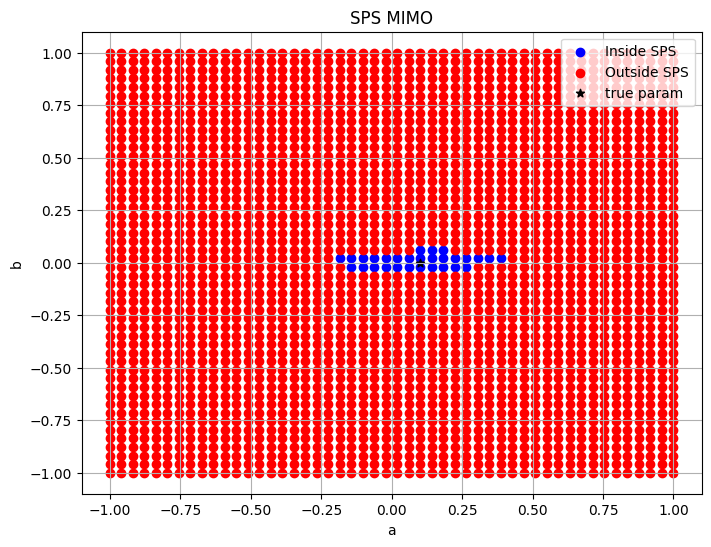

In [89]:
# Grid search

n_params = len(armax_model.A) - 1 + len(armax_model.B)
mins = [-1] * n_params
maxes = [1] * n_params
n_points = 50

a_vals = np.linspace(mins[0], maxes[0], n_points)
b_vals = np.linspace(mins[1], maxes[1], n_points)
F = armax_model.F
L = armax_model.L
 
baseline_in = []
baseline_out = []
center = a1_true, b1_true


for a in a_vals:
    for b in b_vals:
       
        point = np.array([a, b])
        in_sps = sps_test_function( tuple(point), F, L, U, Y, 1, 1)
        if in_sps:
            baseline_in.append([a, b])
        else:
            baseline_out.append([a, b])
 
baseline_in = np.array(baseline_in)
baseline_out = np.array(baseline_out)
 
# Plotting
plt.figure(figsize=(8, 6))
if len(baseline_in):
    plt.scatter(baseline_in[:, 0], baseline_in[:, 1], color='blue', label='Inside SPS')
if len(baseline_out):
    plt.scatter(baseline_out[:, 0], baseline_out[:, 1], color='red', label='Outside SPS')
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS MIMO")
plt.legend()
plt.grid(True)
plt.show()

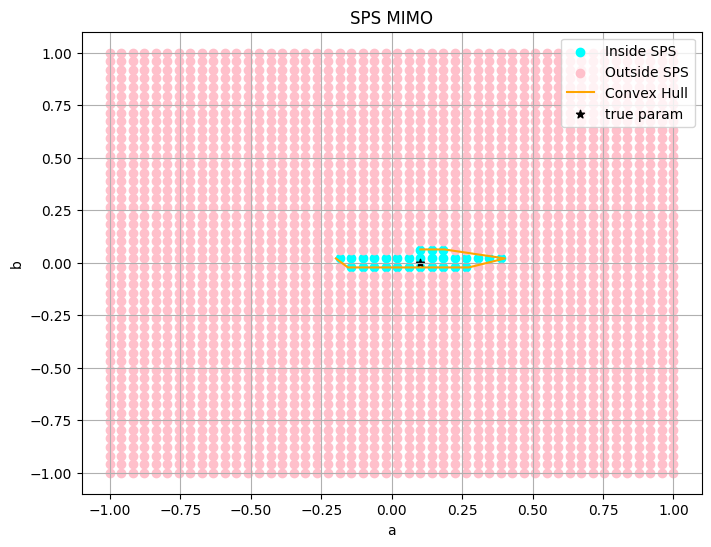

In [90]:
# Hull code
def expand_convex_hull(hull_points, expansion_factor=0.05):
    """Expand the convex hull by a small factor to make it slightly larger."""
    hull_center = np.mean(hull_points, axis=0)
    expanded_points = []
    
    for point in hull_points:
        direction = point - hull_center
        expanded_point = point + direction * expansion_factor
        expanded_points.append(expanded_point)
    
    return np.array(expanded_points)

baseline_hull = ConvexHull(baseline_in)
baseline_expanded = expand_convex_hull(baseline_in[baseline_hull.vertices])

# Plot the baseline hull
plt.figure(figsize=(8, 6))
if len(baseline_in):
    plt.scatter(baseline_in[:, 0], baseline_in[:, 1], color='cyan', label='Inside SPS')
if len(baseline_out):
    plt.scatter(baseline_out[:, 0], baseline_out[:, 1], color='pink', label='Outside SPS')
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='orange', label="Convex Hull")
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.xlabel("a")
plt.ylabel("b")
plt.title("SPS MIMO")
plt.legend()
plt.grid(True)
plt.show()

# Compare two hulls
# https://github.com/mhdadk/sutherland-hodgman
from search.hull_sutherland_hodgman import PolygonClipper
def compare_hulls(hull1, hull2):
    clipper = PolygonClipper(warn_if_empty=True)
    clipped_polygon = clipper(hull1, hull2)
    return clipped_polygon




# KNN Benchmark

In [91]:
# Measure of 'goodness' of confidence region approximation against a baseline
# Calculate the area of the intersection 


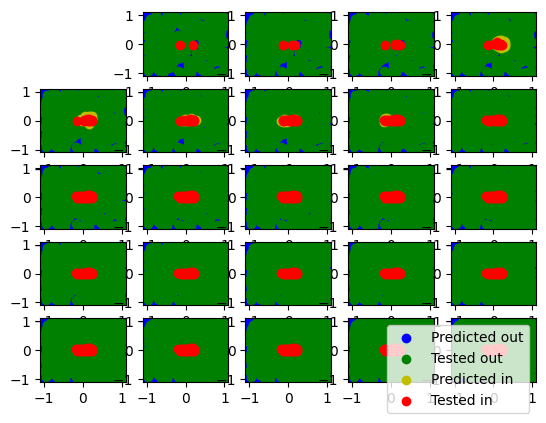

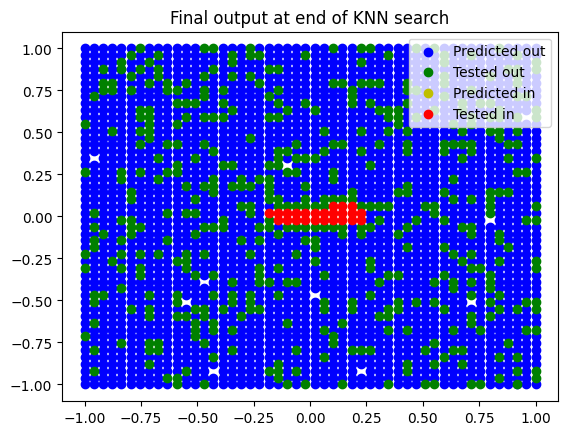

Total SPS calls:  490


In [92]:
n_sps_calls = 0

def search_test_function(coord):
    global n_sps_calls
    n_sps_calls += 1
    return sps_test_function(coord, F=armax_model.F, L=armax_model.L, U=U, Y=Y, n_a = len(armax_model.A) - 1, n_b = len(armax_model.B))


n_params = len(armax_model.A) - 1 + len(armax_model.B)


search = SPSSearch(
        mins=[-1]*n_params,
        maxes=[1]*n_params,
        n_dimensions=n_params,
        n_points=[50]*n_params,
        search_size=0.1,
        test_cb=search_test_function,
    )
search.go()

search.plot_results_2d()
print("Total SPS calls: ", n_sps_calls)

IoU = 0.800


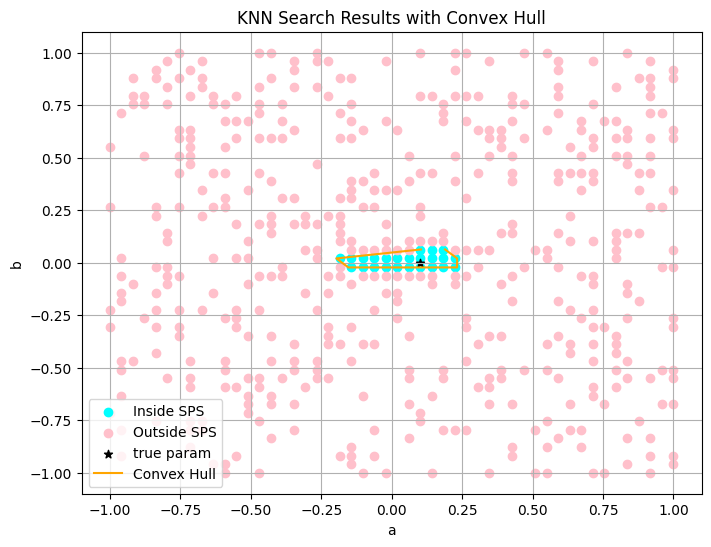

In [93]:
knn_output = np.array(search.get_mapped_output())
knn_in = knn_output[knn_output[:,2] == True]
knn_in = knn_in[:,0:2]
knn_out = knn_output[knn_output[:,2] == False]

knn_hull = ConvexHull(knn_in)
knn_expanded = expand_convex_hull(knn_in[knn_hull.vertices])

knn_intersection = compare_hulls(baseline_expanded[::-1], knn_expanded[::-1])

union_list = np.concatenate([baseline_in, knn_in])
knn_union = ConvexHull(union_list)
union_points = union_list[knn_union.vertices]

knn_union_area = knn_union.area
knn_intersection_area = ConvexHull(knn_intersection).area

print("IoU = %.3f" % (knn_intersection_area / knn_union_area))

# Plot the knn hull
plt.figure(figsize=(8, 6))
if len(knn_in):
    plt.scatter(knn_in[:, 0], knn_in[:, 1], color='cyan', label='Inside SPS')
if len(knn_out):
    plt.scatter(knn_out[:, 0], knn_out[:, 1], color='pink', label='Outside SPS')
plt.scatter(center[0], center[1], color='black', marker='*', label='true param')
plt.plot(knn_expanded[:,0], knn_expanded[:,1], color='orange', label="Convex Hull")
plt.xlabel("a")
plt.ylabel("b")
plt.title("KNN Search Results with Convex Hull")
plt.legend()
plt.grid(True)
plt.show()




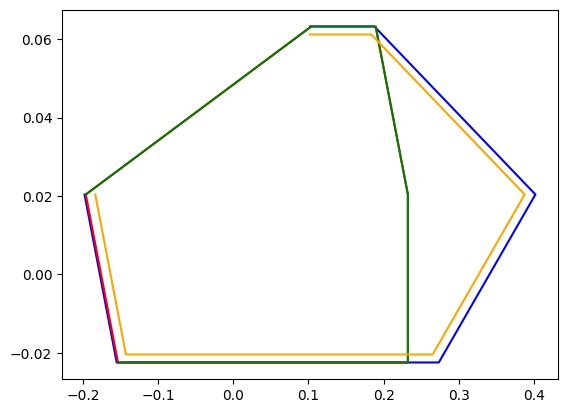

In [94]:
# Hull Comparison
plt.figure()
plt.plot(baseline_expanded[:,0], baseline_expanded[:,1], color='blue', label="Convex Hull (Baseline)")
plt.plot(knn_expanded[:,0], knn_expanded[:,1], color='red', label="Convex Hull (KNN)")
plt.plot(knn_intersection[:,0], knn_intersection[:,1], color='green', label="Intersection Hull")
plt.plot(union_points[:,0], union_points[:,1], color='orange', label="Union Hull")

